In [17]:
# USE https://vectorbt.dev/

In [18]:
import os
import json
import numpy as np
import pandas as pd
import vectorbt as vbt
from lightgbm import LGBMClassifier
from tqdm import tqdm


In [19]:
# import numpy as np
# import pandas as pd

# # CALL ML Models
# def generate_signals(price_df, seed=42):
#     """
#     Генерация сигналов для стратегии.
#     Сейчас рандомная заглушка: 1 = купить, 0 = не держать.
    
#     price_df: DataFrame с индексом дат и колонками тикеров (цены закрытия)
#     """
#     np.random.seed(seed)
#     signals = pd.DataFrame(
#         np.random.randint(0, 2, size=price_df.shape),
#         index=price_df.index,
#         columns=price_df.columns
#     )
#     return signals


In [20]:
from joblib import Parallel, delayed



def compute_weights_for_date(dt, price_index, tickers, strategy):
    print(f"Compute for {dt}")
    if dt not in price_index:
        return None, None
    sig = strategy.generate_signals(dt, tickers)
    active = sig[sig == 1].index
    if len(active) == 0:
        return dt, None
    weights = {ticker: 1 / len(active) for ticker in active}
    return dt, weights


In [21]:
# requirements: vectorbt, pandas, numpy
import numpy as np
import pandas as pd
import vectorbt as vbt

from trading_strategies import BaseStrategy


def run_ml_weekly_strategy(df,
                            strategy: BaseStrategy,
                            init_cash=1_000_000.00,
                            fees=0.005,
                            freq='1D',
                            # size_type='targetpercent',
                            # cash_sharing=True,
                            # call_seq='auto'
                        ):
    """Еженедельная стратегия на основе сигналов ML"""
    # --- Подготовка данных ---
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Date', 'Ticker'])
    price = df.pivot(index='Date', columns='Ticker', values='Close').sort_index()
    tickers = price.columns.tolist()

    # --- Генерация сигналов ---
    # signal = generate_signals(price, seed=42)

    # --- Ребалансировка каждую неделю ---
    rebalance_dates = price.index.to_series().resample('W-MON').last()
    target_weights = pd.DataFrame(0, index=price.index, columns=tickers)

    # for dt in rebalance_dates[400:]:
    #     if dt not in price.index:
    #         continue
    #     # sig = signal.loc[dt]
    #     sig = strategy.generate_signals(dt, tickers)
    #     active = sig[sig == 1].index
        
    #     if len(active) > 0:
    #         target_weights.loc[dt, active] = 1 / len(active) # Равновестно

    # --- Распараллеленный расчёт ---
    results = Parallel(n_jobs=-1, backend='loky')(
    delayed(compute_weights_for_date)(dt, price.index, tickers, strategy)
    for dt in rebalance_dates[100:]
    )
    # --- Собираем обратно ---
    target_weights = pd.DataFrame(0, index=price.index, columns=tickers)
    for dt, weights in results:
        if dt is None or weights is None:
            continue
        for t, w in weights.items():
            target_weights.loc[dt, t] = w

    # --- Заполнение весов через forward fill между ребалансировками ---
    target_weights = target_weights.replace(0, np.nan).ffill().fillna(0)

    # --- Создание портфеля ---
    pf = vbt.Portfolio.from_orders(
        close=price,
        size=target_weights,
        size_type='targetpercent',
        init_cash=init_cash,
        fees=fees,
        freq=freq,
        cash_sharing=True,
        call_seq='auto'
    )

    # return pf, signal, target_weights
    return pf, target_weights


In [22]:
from trading_strategies import LGBMClassifierStrategy, RandomStrategy


data_path = "../data/moex_final_dataset.csv"
# model_path = "../models/meta"

df = pd.read_csv(data_path)
# pf, signals, = run_full_ml_backtest(df, model_path)

# Инициализация стратегии
# strategy = RandomStrategy(df)

# Выбор даты и тикеров
# current_date = pd.Timestamp("2023-07-03")
# tickers = ["SBER", "GAZP", "LKOH"]

# Генерация сигналов
# signals = strategy.generate_signals(current_date, tickers)
# print(signals)

strategy = LGBMClassifierStrategy(df)
# pf, stats_series, stats_df = run_ml_weekly_strategy(df)
pf, target_weights = run_ml_weekly_strategy(df, strategy)
# signals = run_full_ml_backtest(df, model_path)


✅ Загружено 19,261 строк по 66 тикерам.
Compute for 2019-12-23 00:00:00
Compute for 2020-01-27 00:00:00

Обучаем модель на 2544 строк (до 2019-12-23)
Обучение модели...

Обучаем модель на 2751 строк (до 2020-01-27)
Обучение модели...
Compute for 2020-02-10 00:00:00

Обучаем модель на 2842 строк (до 2020-02-10)
Обучение модели...
Compute for 2019-12-09 00:00:00

Обучаем модель на 2456 строк (до 2019-12-09)
Обучение модели...
Compute for 2019-12-16 00:00:00Compute for 2020-01-13 00:00:00


Обучаем модель на 2496 строк (до 2019-12-16)
Обучение модели...
Compute for 2020-01-20 00:00:00

Обучаем модель на 2652 строк (до 2020-01-13)
Обучение модели...
Compute for 2019-12-30 00:00:00
Compute for 2020-01-06 00:00:00
Compute for 2020-02-03 00:00:00

Обучаем модель на 2584 строк (до 2019-12-30)
Обучение модели...

Обучаем модель на 2607 строк (до 2020-01-06)
Обучение модели...

Обучаем модель на 2800 строк (до 2020-02-03)

Обучаем модель на 2701 строк (до 2020-01-20)
Обучение модели...
Обучение 

/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_36762/1232078824.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.041666666666666664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_36762/1232078824.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.041666666666666664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_36762/1232078824.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.041666666666666664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/lh/9k36l4vn35v4qnj

<Axes: xlabel='Date'>

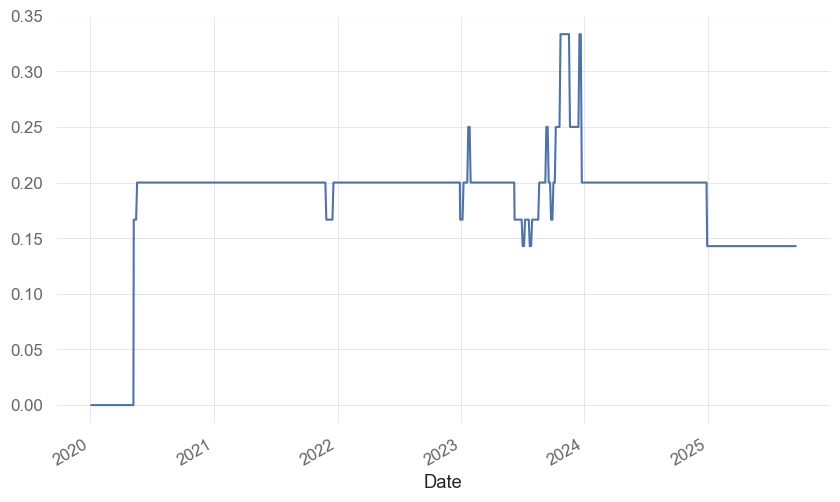

In [23]:
target_weights[target_weights.index > '2020-01-01'].SBER.plot()

In [24]:
pf.stats()
pf.value().vbt.plot()
# pf.returns().vbt.plot_histogram()
pf.sharpe_ratio()


np.float64(0.4659187671432215)

In [25]:
# print(stats_series)
# display(stats_df)  # more detailed table
# print(per_ret.sort_values(ascending=False).head(10))


In [26]:
pf.value().vbt.plot(title="Portfolio Value Over Time")


FigureWidget({
    'data': [{'name': 'group',
              'showlegend': True,
              'type': 'scatter',
              'uid': '3f58b5ba-15a6-423f-b6f4-393ff6d7f617',
              'x': array([datetime.datetime(2018, 1, 5, 0, 0),
                          datetime.datetime(2018, 1, 15, 0, 0),
                          datetime.datetime(2018, 1, 18, 0, 0), ...,
                          datetime.datetime(2025, 9, 16, 0, 0),
                          datetime.datetime(2025, 9, 17, 0, 0),
                          datetime.datetime(2025, 9, 18, 0, 0)], shape=(1816,), dtype=object),
              'y': array([1000000.        , 1000000.        , 1000000.        , ...,
                          1499537.60519859, 1499537.60519859, 1499537.60519859], shape=(1816,))}],
    'layout': {'height': 350,
               'legend': {'orientation': 'h',
                          'traceorder': 'normal',
                          'x': 1,
                          'xanchor': 'right',
                 

In [27]:
pf.plot()


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#7f7f7f'},
              'name': 'Benchmark',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'a8823443-a641-4212-b7e5-da584cfe3c16',
              'x': array([datetime.datetime(2018, 1, 5, 0, 0),
                          datetime.datetime(2018, 1, 15, 0, 0),
                          datetime.datetime(2018, 1, 18, 0, 0), ...,
                          datetime.datetime(2025, 9, 16, 0, 0),
                          datetime.datetime(2025, 9, 17, 0, 0),
                          datetime.datetime(2025, 9, 18, 0, 0)], shape=(1816,), dtype=object),
              'xaxis': 'x',
              'y': array([1.        , 1.00138399, 1.00138399, ..., 1.3647175 , 1.36040068,
                          1.35669867], shape=(1816,)),
              'yaxis': 'y'},
             {'hoverinfo': 'skip',
              'legendgroup': '1',
              'line': {'color': 'rgba(0, 0, 0, 0)', '

In [28]:
pf.returns().vbt.plot(title="Daily Returns")


FigureWidget({
    'data': [{'name': 'group',
              'showlegend': True,
              'type': 'scatter',
              'uid': '37622a14-c23f-457a-be47-096043a83327',
              'x': array([datetime.datetime(2018, 1, 5, 0, 0),
                          datetime.datetime(2018, 1, 15, 0, 0),
                          datetime.datetime(2018, 1, 18, 0, 0), ...,
                          datetime.datetime(2025, 9, 16, 0, 0),
                          datetime.datetime(2025, 9, 17, 0, 0),
                          datetime.datetime(2025, 9, 18, 0, 0)], shape=(1816,), dtype=object),
              'y': array([0., 0., 0., ..., 0., 0., 0.], shape=(1816,))}],
    'layout': {'height': 350,
               'legend': {'orientation': 'h',
                          'traceorder': 'normal',
                          'x': 1,
                          'xanchor': 'right',
                          'y': 1.02,
                          'yanchor': 'bottom'},
               'margin': {'b': 30, 'l': 30

In [29]:
pf.drawdowns.plot(title="Drawdowns")


FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'group',
              'showlegend': True,
              'type': 'scatter',
              'uid': '66c3699a-db4a-4c42-bb49-3811c2224681',
              'x': array([datetime.datetime(2018, 1, 5, 0, 0),
                          datetime.datetime(2018, 1, 15, 0, 0),
                          datetime.datetime(2018, 1, 18, 0, 0), ...,
                          datetime.datetime(2025, 9, 16, 0, 0),
                          datetime.datetime(2025, 9, 17, 0, 0),
                          datetime.datetime(2025, 9, 18, 0, 0)], shape=(1816,), dtype=object),
              'y': array([1000000.        , 1000000.        , 1000000.        , ...,
                          1499537.60519859, 1499537.60519859, 1499537.60519859], shape=(1816,))},
             {'customdata': array([[ 3],
                                   [ 4],
                                   [14],
                                   [19],
                

In [30]:
pf.plot(subplots=['orders', 'value', 'drawdowns'], title="Portfolio Overview")


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data



FigureWidget({
    'data': [{'hoverinfo': 'skip',
              'legendgroup': '0',
              'line': {'color': 'rgba(0, 0, 0, 0)', 'width': 0},
              'opacity': 0,
              'showlegend': False,
              'type': 'scatter',
              'uid': 'e9bc9d22-5b98-4c48-9925-44602153c9f8',
              'x': array([datetime.datetime(2018, 1, 5, 0, 0),
                          datetime.datetime(2018, 1, 15, 0, 0),
                          datetime.datetime(2018, 1, 18, 0, 0), ...,
                          datetime.datetime(2025, 9, 16, 0, 0),
                          datetime.datetime(2025, 9, 17, 0, 0),
                          datetime.datetime(2025, 9, 18, 0, 0)], shape=(1816,), dtype=object),
              'xaxis': 'x',
              'y': array([1000000., 1000000., 1000000., ..., 1000000., 1000000., 1000000.],
                         shape=(1816,)),
              'yaxis': 'y'},
             {'connectgaps': False,
              'fill': 'tonexty',
              'f

In [31]:
def plot_allocation(rb_pf):
    rb_asset_value = rb_pf.asset_value(group_by=False)
    rb_value = rb_pf.value()
    rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
    rb_dates = rb_pf.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=target_weights.columns,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show()

plot_allocation(pf)


In [32]:
pf.stats()

Start                                 2018-01-05 00:00:00
End                                   2025-09-18 00:00:00
Period                                 1816 days 00:00:00
Start Value                                     1000000.0
End Value                                  1499537.605199
Total Return [%]                                49.953761
Benchmark Return [%]                            35.669867
Max Gross Exposure [%]                              100.0
Total Fees Paid                              27552.114746
Max Drawdown [%]                                38.505441
Max Drawdown Duration                   345 days 00:00:00
Total Trades                                          735
Total Closed Trades                                   707
Total Open Trades                                      28
Open Trade PnL                                        0.0
Win Rate [%]                                    81.895332
Best Trade [%]                                 304.055087
Worst Trade [%